In [32]:
import pandas as pd
import numpy as np
from sklearn import datasets
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.utils import resample
from sklearn.metrics import confusion_matrix, classification_report
from imblearn.over_sampling import SMOTE, ADASYN

import warnings
warnings.filterwarnings('ignore')

In [73]:
heart=pd.read_excel("./cleveland.xlsx")

In [74]:
heart.head()

,age,sex,cp,trestbps,chol,fbs,restecg,thalach,exang,oldpeak,slope,ca,thal,num
0,63.0,1.0,1.0,145.0,233.0,1.0,2.0,150.0,0.0,2.3,3.0,0.0,6.0,negative
1,37.0,1.0,3.0,130.0,250.0,0.0,0.0,187.0,0.0,3.5,3.0,0.0,3.0,negative
2,41.0,0.0,2.0,130.0,204.0,0.0,2.0,172.0,0.0,1.4,1.0,0.0,3.0,negative
3,56.0,1.0,2.0,120.0,236.0,0.0,0.0,178.0,0.0,0.8,1.0,0.0,3.0,negative
4,57.0,0.0,4.0,120.0,354.0,0.0,0.0,163.0,1.0,0.6,1.0,0.0,3.0,negative


In [75]:
heart["dummy_num"]=heart["num"].replace({"negative":0, "positive":1})
heart=heart.replace({"<null>":np.nan})

In [76]:
len(heart)

173

In [77]:
heart.dummy_num.value_counts()

0    160
1     13
Name: dummy_num, dtype: int64

In [78]:
heart_corr=heart.corr()

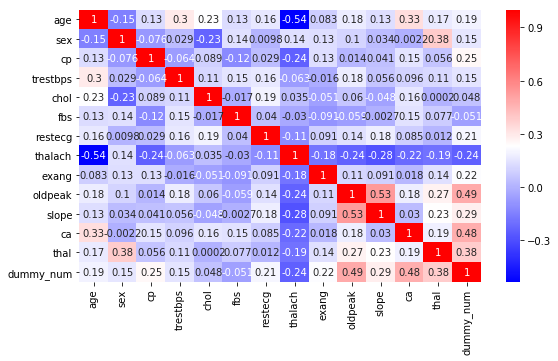

In [79]:
plt.figure(figsize=(9,5))
sns.heatmap(heart_corr, cmap="bwr", annot=True)
plt.show()

In [80]:
y=heart["dummy_num"]
X=heart.drop("dummy_num", axis=1)

In [160]:
def model_test(X, y, tip):
    X_eğitim, X_test, y_eğitim, y_test =  train_test_split(X, y, test_size=0.20, random_state=286, stratify = y)
    
    logreg_model = LogisticRegression()
    logreg_model.fit(X_eğitim, y_eğitim)

    tahmin_eğitim = logreg_model.predict(X_eğitim)
    tahmin_test = logreg_model.predict(X_test)
    
    egt_matris = confusion_matrix(y_eğitim, tahmin_eğitim)
    test_matris = confusion_matrix(y_test, tahmin_test)

    tablo=pd.DataFrame(columns={"Dogruluk (Egt)", "Hassasiyet (Egt)", "Duyarlılık (Egt)", "F1 (Egt)",
                         "Dogruluk (Tst)", "Hassasiyet (Tst)", "Duyarlılık (Tst)", "F1 (Tst)"})
    
    egt_dogru=(egt_matris[0][0]+egt_matris[1][1])/(egt_matris[0][0]+egt_matris[0][1]+egt_matris[1][0]+egt_matris[1][1])
    egt_hassas=egt_matris[1][1]/(egt_matris[1][1]+egt_matris[0][1])
    egt_duyar=egt_matris[1][1]/(egt_matris[1][1]+egt_matris[1][0])
    egt_f1=(2*egt_hassas*egt_duyar)/(egt_hassas+egt_duyar)
    
    test_dogru=(test_matris[0][0]+test_matris[1][1])/(test_matris[0][0]+test_matris[0][1]+test_matris[1][0]+test_matris[1][1])
    test_hassas=test_matris[1][1]/(test_matris[1][1]+test_matris[0][1])
    test_duyar=test_matris[1][1]/(test_matris[1][1]+test_matris[1][0])
    test_f1=(2*test_hassas*test_duyar)/(test_hassas+test_duyar)
    
    row = pd.Series({"Dogruluk (Egt)":egt_dogru, 
                    "Hassasiyet (Egt)":egt_hassas, 
                    "Duyarlılık (Egt)":egt_duyar, 
                    "F1 (Egt)":egt_f1,
                        
                    "Dogruluk (Tst)":test_dogru, 
                    "Hassasiyet (Tst)":test_hassas, 
                    "Duyarlılık (Tst)":test_duyar, 
                    "F1 (Tst)":test_f1},
                    name=tip)
   
    tablo=tablo.append(row)
    
    return  tablo

In [133]:
X=heart[["oldpeak", "ca", "thal", "thalach", "slope", "cp"]]

In [198]:
tablo=pd.DataFrame(columns={"Dogruluk (Egt)", "Hassasiyet (Egt)", "Duyarlılık (Egt)", "F1 (Egt)",
                         "Dogruluk (Tst)", "Hassasiyet (Tst)", "Duyarlılık (Tst)", "F1 (Tst)"})

In [199]:
tip="Dengeli Olmayan"
tablo=tablo.append(model_test(X, y, tip))

In [200]:
normal=heart[heart["dummy_num"]==0]
sahte=heart[heart["dummy_num"]==1]

sahte_artirilmis=resample(sahte, replace=True, random_state=286, n_samples=len(normal))

esit=pd.concat([normal, sahte_artirilmis])
esit["dummy_num"].value_counts()

X1=esit[["oldpeak", "ca", "thal", "thalach", "slope", "cp"]]
y1=esit["dummy_num"]

tip="Artirilmis"
tablo=tablo.append(model_test(X1, y1, tip))

In [201]:
X2=heart[["oldpeak", "ca", "thal", "thalach", "slope", "cp"]]
y2=heart["dummy_num"]

sm=SMOTE(random_state=286, ratio=1)
X_sm, y_sm=sm.fit_sample(X2, y2)

tip="SMOTE"
tablo=tablo.append(model_test(X_sm, y_sm, tip))

In [202]:
X3=heart[["oldpeak", "ca", "thal", "thalach", "slope", "cp"]]
y3=heart["dummy_num"]

ada=ADASYN()
X_ada, y_ada=ada.fit_sample(X3, y3)

tip="ADASYN"
tablo=tablo.append(model_test(X_ada, y_ada, tip))

In [241]:
sutunlar=["Dogruluk (Egt)", "Hassasiyet (Egt)", "Duyarlılık (Egt)", "F1 (Egt)", 
          "Dogruluk (Tst)", "Hassasiyet (Tst)", "Duyarlılık (Tst)", "F1 (Tst)"]

row=pd.Series({"Dogruluk (Egt)":tablo[tablo["Dogruluk (Egt)"]==tablo["Dogruluk (Egt)"].max()].index[0], 
                "Hassasiyet (Egt)":tablo[tablo["Hassasiyet (Egt)"]==tablo["Hassasiyet (Egt)"].max()].index[0], 
                "Duyarlılık (Egt)":tablo[tablo["Duyarlılık (Egt)"]==tablo["Duyarlılık (Egt)"].max()].index[0], 
                "F1 (Egt)":tablo[tablo["F1 (Egt)"]==tablo["F1 (Egt)"].max()].index[0],
                        
                "Dogruluk (Tst)":tablo[tablo["Dogruluk (Tst)"]==tablo["Dogruluk (Tst)"].max()].index[0], 
                "Hassasiyet (Tst)":tablo[tablo["Hassasiyet (Tst)"]==tablo["Hassasiyet (Tst)"].max()].index[0], 
                "Duyarlılık (Tst)":tablo[tablo["Duyarlılık (Tst)"]==tablo["Duyarlılık (Tst)"].max()].index[0], 
                "F1 (Tst)":tablo[tablo["F1 (Tst)"]==tablo["F1 (Tst)"].max()].index[0]},
                name="En yüksek deger")
   
tablo=tablo.append(row)

tablo

,Hassasiyet (Egt),Hassasiyet (Tst),Duyarlılık (Egt),Duyarlılık (Tst),F1 (Egt),Dogruluk (Tst),F1 (Tst),Dogruluk (Egt)
Dengeli Olmayan,0.777778,1,0.7,0.333333,0.736842,0.942857,0.5,0.963768
Artirilmis,0.948148,0.914286,1,1,0.973384,0.953125,0.955224,0.972656
SMOTE,0.955224,0.914286,1,1,0.977099,0.953125,0.955224,0.976562
ADASYN,0.962687,0.916667,1,1,0.980989,0.953846,0.956522,0.980545
En yüksek deger,ADASYN,Dengeli Olmayan,Artirilmis,Artirilmis,ADASYN,ADASYN,ADASYN,ADASYN
